# Grafici sui dati sul Corona Virus
## Se non vuoi vedere il codice, vai in basso e troverai le figure

Qui ci andrebbe una introduzione degna di questo nome xxx xxx xxxx

Importiamo le librerie necessarie a fare statistiche e grafici

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Carichiamo i dati, togliamo le righe con valori mancanti e vediamo un'anteprima

In [2]:
df = pd.read_csv('./../publication/provinceArchivioISTAT.csv')
# in alternativa URL diretta:
# https://raw.githubusercontent.com/ondata/covid19italia/master/publication/provinceArchivio.csv

df = df.dropna()

df.sample(5)

,provincia,numero,regione,datetime,codiceISTAT
162,Trento,5.0,TRENTINO ALTO ADIGE,2020-03-04,22.0
247,Bologna,3.0,EMILIA-ROMAGNA,2020-03-02,237.0
218,Taranto,3.0,PUGLIA,2020-03-03,73.0
205,Monza Brianza,9.0,LOMBARDIA,2020-03-03,108.0
146,Lecce,1.0,PUGLIA,2020-03-04,75.0


## Attenzione
Concentriamoci sulla colonna "numero".
Questa contiene i malati accertati fino a quel giorno, quindi non avrebbe senso sommare le osservazioni precedenti sullo stesso luogo.

Prepariamo una colonna contenente solo i NUOVI contagiati in un certo giorno.

(decommenta i print nel codice per vedere i passaggi uno per uno)

In [3]:
# ordiniamo i dati in base a provincia e giorno
df = df.sort_values(by=['provincia', 'datetime'])

# sottraiamo il numero dei contagiati di un giorno da quelli del giorno precedente
# prima di fare la sottrazione dobbiamo raggruppare per provincia
df['nuovi_contagi'] = df[ ['numero', 'provincia'] ].groupby('provincia').diff()

# esempio
df[ df['provincia'] == 'Milano' ]

,provincia,numero,regione,datetime,codiceISTAT,nuovi_contagi
270,Milano,58.0,LOMBARDIA,2020-03-02,215.0,NaN
204,Milano,93.0,LOMBARDIA,2020-03-03,215.0,35.0
124,Milano,145.0,LOMBARDIA,2020-03-04,215.0,52.0
37,Milano,197.0,LOMBARDIA,2020-03-05,215.0,52.0


Da adesso in poi ci possiamo distinguere le nostre analisi, tenendo conto degli andamenti `nuovi_contagi` e del numero cumulativo con `numero`.

In [4]:
ultimo_giorno = df['datetime'].max()
df_ultimo_giorno = df[ df['datetime'] == ultimo_giorno ]
totale_contagiati = df_ultimo_giorno['numero'].sum()
print(f'\n\nTotale contagiati al {ultimo_giorno}: {totale_contagiati}')



Totale contagiati al 2020-03-05: 3725.0


## I contagiati per regione, provincia, data

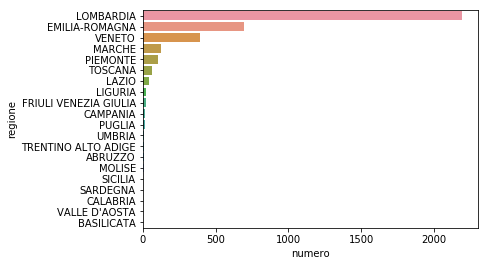

                       numero
regione                      
LOMBARDIA              2189.0
EMILIA-ROMAGNA          694.0
VENETO                  393.0
MARCHE                  124.0
PIEMONTE                102.0
TOSCANA                  61.0
LAZIO                    43.0
LIGURIA                  24.0
FRIULI VENEZIA GIULIA    21.0
CAMPANIA                 17.0
PUGLIA                   14.0
UMBRIA                    9.0
TRENTINO ALTO ADIGE       8.0
ABRUZZO                   8.0
MOLISE                    7.0
SICILIA                   4.0
SARDEGNA                  2.0
CALABRIA                  2.0
VALLE D'AOSTA             2.0
BASILICATA                1.0


In [5]:
df_by_regione = df_ultimo_giorno[ ['regione', 'numero'] ].groupby('regione')
df_by_regione = df_by_regione.sum().sort_values(by='numero', ascending=False)

sns.barplot(data=df_by_regione.reset_index(), x='numero', y='regione')
plt.show()

print(df_by_regione)

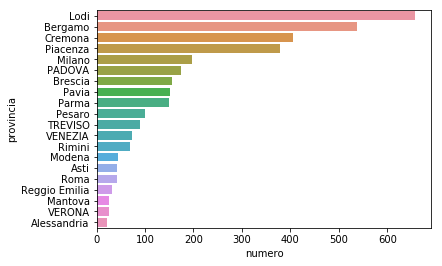

        provincia  numero
35           Lodi   658.0
30        Bergamo   537.0
33        Cremona   406.0
14       Piacenza   378.0
37         Milano   197.0
82         PADOVA   175.0
31        Brescia   155.0
39          Pavia   151.0
13          Parma   150.0
46         Pesaro   100.0
84        TREVISO    89.0
85        VENEZIA    73.0
17         Rimini    68.0
12         Modena    45.0
49           Asti    43.0
24           Roma    42.0
16  Reggio Emilia    31.0
36        Mantova    26.0
86         VERONA    25.0
48    Alessandria    22.0


In [6]:
df_by_provincia = df_ultimo_giorno.sort_values(by='numero', ascending=False)

# prendiamo in considerazione solo le prime 20 più colpite
df_by_provincia = df_by_provincia.head(20)

sns.barplot(data=df_by_provincia, x='numero', y='provincia')
plt.show()

print(df_by_provincia[ ['provincia', 'numero'] ])

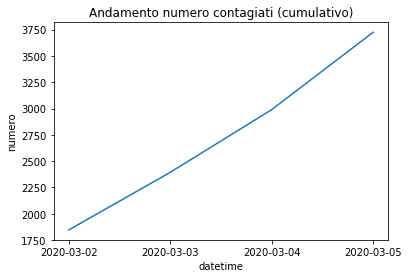

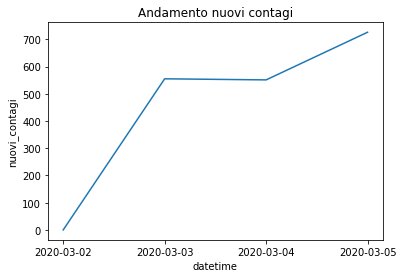

In [7]:
# raggruppa in base al giorno
df_by_datetime = df[ ['datetime', 'numero', 'nuovi_contagi'] ].groupby('datetime')
df_by_datetime = df_by_datetime.sum().sort_values(by='datetime')

# contagi cumulativi
g = sns.lineplot(data=df_by_datetime.reset_index(), x='datetime', y='numero')
g.set_title('Andamento numero contagiati (cumulativo)')
plt.show()

# nuovi contagi
g = sns.lineplot(data=df_by_datetime.reset_index(), x='datetime', y='nuovi_contagi')
g.set_title('Andamento nuovi contagi')
plt.show()


## Mappa dei contagi per provincia

**N.B. bisogna installare:**
* **geopandas**
* **descartes**

In [9]:
df_by_provincia.head()

,provincia,numero,regione,datetime,codiceISTAT,nuovi_contagi
35,Lodi,658.0,LOMBARDIA,2020-03-05,98,99.0
30,Bergamo,537.0,LOMBARDIA,2020-03-05,16,114.0
33,Cremona,406.0,LOMBARDIA,2020-03-05,19,73.0
14,Piacenza,378.0,EMILIA-ROMAGNA,2020-03-05,33,59.0
37,Milano,197.0,LOMBARDIA,2020-03-05,215,52.0


In [10]:
#!pip install geopandas
#!pip install descartes

In [11]:
import geopandas as gpd

In [12]:
italy = gpd.read_file('./../risorse/prov2019.geojson')

Attenzione! Qui ho fatto *merge* con le denominazioni delle province, potete farlo anche col codice ma và prima convertito in intero.

Imputo 0 ai missing values, ipotizzando che non ci siano stati casi se manca il valore.

In [23]:
italy['DEN_UTS'] = italy['DEN_UTS'].str.lower()
df_by_provincia['provincia'] = df_by_provincia['provincia'].str.lower()
covid19map = italy.merge(df_by_provincia, how = 'left',left_on = 'DEN_UTS', right_on = 'provincia')
covid19map['numero'].fillna(0, inplace = True)

Costruisco la variabile *covid19 rate*, non è altro che la percentuale di casi per provincia (calcolata su tutti i casi italiani).

In [47]:
covid19map['covid19 rate'] = covid19map['numero']/covid19map['numero'].sum()

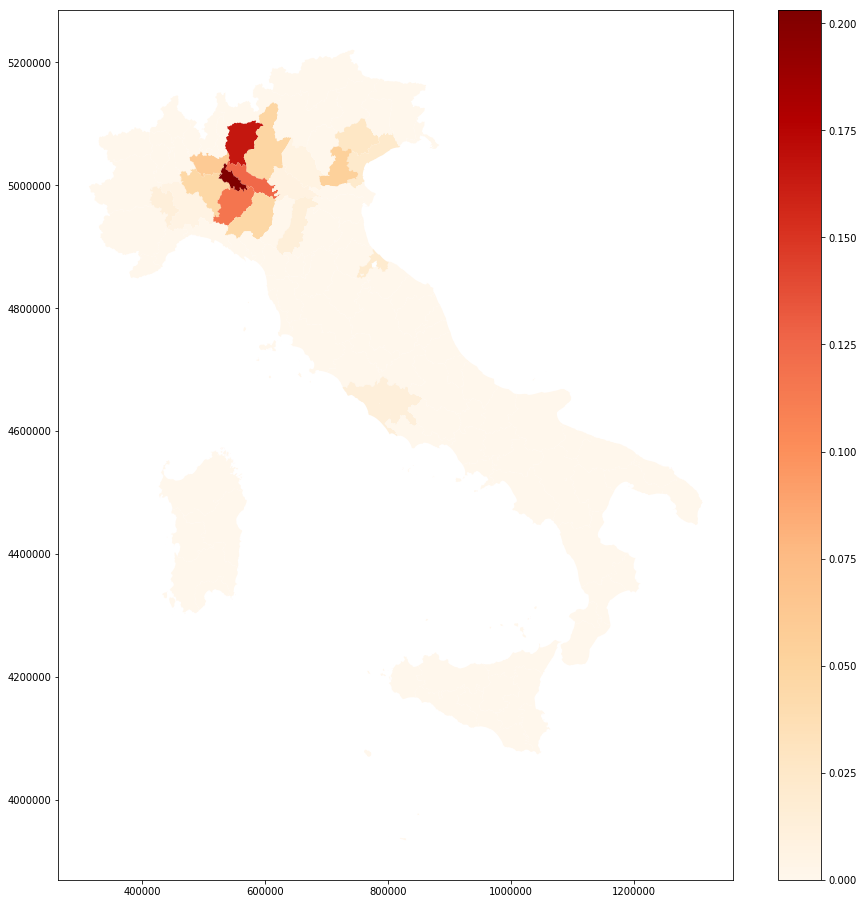

In [48]:
fig, ax = plt.subplots(1, figsize=(16, 16))
covid19map.plot(column='covid19 rate', ax=ax, cmap='OrRd', legend=True)
plt.show()